Dataset : [Ovarian Cancer Risk and Progression Data](https://www.kaggle.com/datasets/datasetengineer/ovarian-cancer-risk-and-progression-data/data)

# 0. Import

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Loading

In [ ]:
FILE_PATH = '/content/drive/My Drive/졸업프로젝트/TestDataset/'
CSV_FILE_PATH = Path(FILE_PATH) / 'Ovarian_patient_data.csv'

In [ ]:
OUTPUT_DIR = Path(FILE_PATH) / "Processed_Clinical_Data"

OUTPUT_DL_TRAIN_NPZ = 'dl_train_data.npz'
OUTPUT_DL_TEST_NPZ = 'dl_test_data.npz'

OUTPUT_RAW_TRAIN_NPZ = 'tree_raw_train_data.npz'
OUTPUT_RAW_TEST_NPZ = 'tree_raw_test_data.npz'

OUTPUT_INDEX_NAME = 'split_indices.npz'

In [ ]:
try:
    df_clinical = pd.read_csv(CSV_FILE_PATH)
    print(f"Data loaded successfully from: {CSV_FILE_PATH.name}")
except FileNotFoundError:
    print(f"[ERROR] CSV file not found at {CSV_FILE_PATH}")
    exit()
except Exception as e:
    print(f"[ERROR] Error loading CSV file: {e}")
    exit()

Data loaded successfully from: Ovarian_patient_data.csv


# 2. Data Structure

In [ ]:
print("\n---  Dataset Information ---")
df_clinical.info()

print("\n--- Descriptive Statistics ---")
# 숫자형 column의 기술 통계량 확인
print(df_clinical.describe().T)

# 3. 결측치 확인
print("\n--- 결측치 현황 ---")
missing_count = df_clinical.isnull().sum()
missing_ratio = (df_clinical.isnull().sum() / len(df_clinical)) * 100

# 결측치가 있는 컬럼만 정리
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio (%)': missing_ratio
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Ratio (%)', ascending=False)

if missing_info.empty:
    print("No missing values found in the dataset.")
else:
    print("[WARN] Missing values found in the following columns:")
    print(missing_info)

    # 결측치 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_info.index, y='Missing Ratio (%)', data=missing_info, palette="Reds_d")
    plt.xticks(rotation=45, ha='right')
    plt.title('Missing Value Ratio by Column', fontsize=16)
    plt.ylabel('Missing Ratio (%)')
    plt.tight_layout()
    plt.show()



---  Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Timestamp               200100 non-null  object 
 1   Age                     200100 non-null  float64
 2   BMI                     200100 non-null  float64
 3   Comorbidity             200100 non-null  int64  
 4   Symptom                 200100 non-null  int64  
 5   CA125                   200100 non-null  float64
 6   CancerStage             200100 non-null  int64  
 7   Histopathology          200100 non-null  object 
 8   PreviousTreatment       200100 non-null  int64  
 9   MenstrualHistory        200100 non-null  object 
 10  Ethnicity               200100 non-null  object 
 11  Smoking                 200100 non-null  int64  
 12  Alcohol                 200100 non-null  int64  
 13  Residence               200100 non-null  obj

In [ ]:
print(df_clinical.head())

             Timestamp        Age        BMI  Comorbidity  Symptom  \
0  2019-01-01 00:00:00  67.450712  27.468755            0        0   
1  2019-01-01 01:00:00  57.926035  27.736019            1        0   
2  2019-01-01 02:00:00  69.715328  22.285561            0        0   
3  2019-01-01 03:00:00  82.845448  31.315519            1        1   
4  2019-01-01 04:00:00  56.487699  17.056296            1        0   

        CA125  CancerStage Histopathology  PreviousTreatment MenstrualHistory  \
0   66.738329            0         serous                  0          regular   
1   28.390526            1     clear cell                  0          regular   
2  118.120787            3     clear cell                  1          regular   
3    6.418598            0         serous                  1          regular   
4   65.912779            1       mucinous                  0          regular   

   ... RadiomicIntensity  RadiomicShape  DopplerVelocity Parity  \
0  ...         57.572038 

# 3. Outlier Analysis

Numerical columns found: ['Age', 'BMI', 'CA125', 'GeneExpression', 'DNAMethylation', 'miRNA', 'TumorSize', 'EnhancementPattern', 'RadiomicTexture', 'RadiomicIntensity', 'RadiomicShape', 'DopplerVelocity', 'MenarcheAge', 'MenopauseAge', 'ProgressionProbability']


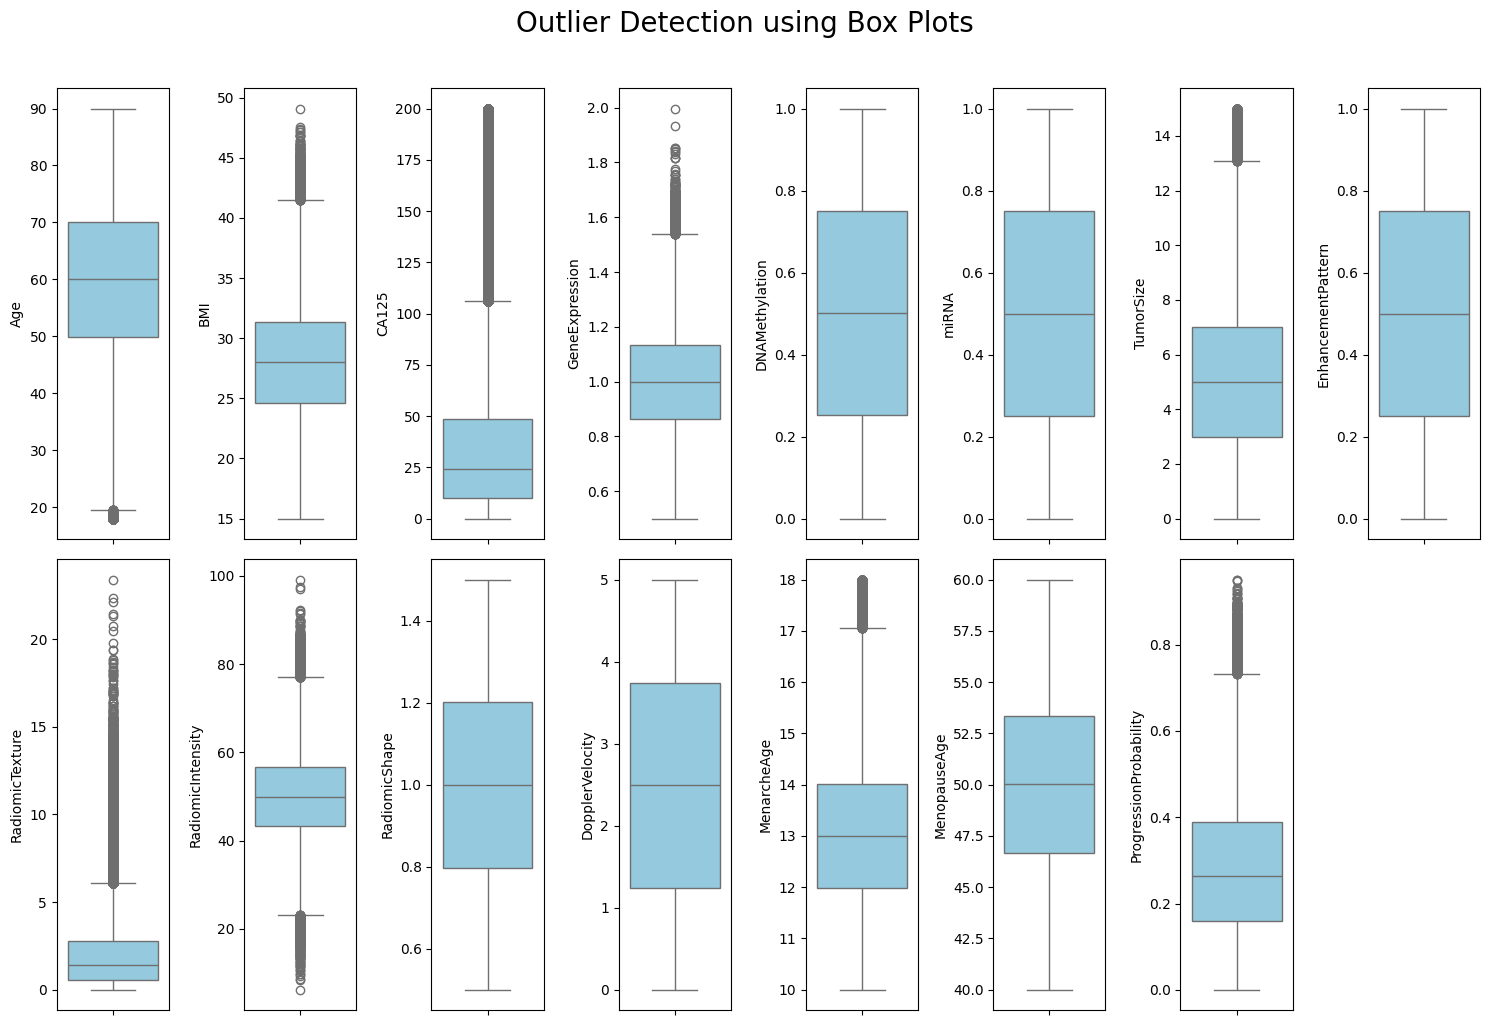

In [ ]:
# 수치형 column만 가져옴
numerical_cols = df_clinical.select_dtypes(include=['float64']).columns.tolist()

if not numerical_cols:
    print("[WARN] No numerical columns found for outlier analysis.")
else:
    print(f"Numerical columns found: {numerical_cols}")

    # 이상치 Box Plot으로 시각화
    plt.figure(figsize=(15, 10))
    plt.suptitle('Outlier Detection using Box Plots', fontsize=20, y=1.02)

    # 각 수치형 column에 대해 Box Plot 생성
    for i, col in enumerate(numerical_cols):
        plt.subplot(2, int(np.ceil(len(numerical_cols)/2)), i + 1)
        sns.boxplot(y=df_clinical[col], color='skyblue')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

In [ ]:
def handle_outliers(df, col):
        """ IQR 기반의 이상치 처리 (Capping) 함수 """
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체 (Capping)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        return df

# 4. Preprocessing

In [ ]:
def preprocess_and_split(df, test_size=0.2, random_state=42):

    df_processed = df.copy()

    # 1. 사용할 column 정의
    # Timestamp, RiskLabel 제외
    df_features = df_processed.drop(columns=['Timestamp', 'RiskLabel'])

    numerical_cols = df_features.select_dtypes(include=['float64']).columns.tolist()
    categorical_cols = df_features.select_dtypes(include=['int64', 'object']).columns.tolist()

    print(f"Identified Numerical Features ({len(numerical_cols)}): {numerical_cols}...")
    print(f"Identified Categorical Features ({len(categorical_cols)}): {categorical_cols}")

    # 2. proxy label 생성
    # RiskLabel >= 2 -> malignant(1), RiskLabel <= 1 -> benign(0)
    df_processed['RiskLabel_Binary'] = (df_processed['RiskLabel'] >= 2).astype(np.int64)
    Y_clin = df_processed['RiskLabel_Binary'].values

    # 3. 이상치 처리
    for col in numerical_cols:
        df_features = handle_outliers(df_features, col)
    print("IQR Capping applied to numerical features.")

    # 4. 공통 Split Index 생성
    indices = df_processed.index.values
    train_idx, test_idx = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        stratify=Y_clin
    )

    df_num_capped_train = df_features.loc[train_idx, numerical_cols].reset_index(drop=True)
    df_num_capped_test = df_features.loc[test_idx, numerical_cols].reset_index(drop=True)

    # One-Hot Encoding (전체 데이터에 fit하고 slicing - 컬럼 일관성 유지)
    df_categorical_full = pd.get_dummies(df_features[categorical_cols], drop_first=True)
    df_cat_train = df_categorical_full.loc[train_idx].reset_index(drop=True)
    df_cat_test = df_categorical_full.loc[test_idx].reset_index(drop=True)

    # --- Tree 모델용 raw 데이터 전처리 (Capping + One-Hot) ---

    df_raw_train = pd.concat([df_num_capped_train, df_cat_train], axis=1)
    df_raw_test = pd.concat([df_num_capped_test, df_cat_test], axis=1)

    X_raw_train = df_raw_train.values.astype(np.float32)
    X_raw_test = df_raw_test.values.astype(np.float32)

    # --- DL 모델용 Feature Vector 생성 (Standardization 추가) ---

    scaler = StandardScaler()

    # Train data : fit_transform 적용
    X_numerical_train = df_num_capped_train.values
    X_numerical_train_scaled = scaler.fit_transform(X_numerical_train)
    df_num_scaled_train = pd.DataFrame(X_numerical_train_scaled, columns=numerical_cols)

    # Test data : fit 없이 transform만 적용
    X_numerical_test = df_num_capped_test.values
    X_numerical_test_scaled = scaler.transform(X_numerical_test)
    df_num_scaled_test = pd.DataFrame(X_numerical_test_scaled, columns=numerical_cols)

    # 최종 DL Feature Vector 결합
    X_dl_train = pd.concat([df_num_scaled_train, df_cat_train], axis=1).values.astype(np.float32)
    X_dl_test = pd.concat([df_num_scaled_test, df_cat_test], axis=1).values.astype(np.float32)

    # 공통 label
    Y_train = Y_clin[train_idx]
    Y_test = Y_clin[test_idx]

    print(f"Final DL Features dimension: {X_dl_train.shape[1]}")
    print(f"Train/Test Split ratio: {len(train_idx)} / {len(test_idx)}")

    return X_dl_train, X_dl_test, X_raw_train, X_raw_test, Y_train, Y_test, train_idx, test_idx


In [ ]:
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

X_dl_train, X_dl_test, X_raw_train, X_raw_test, Y_train, Y_test, train_idx, test_idx = preprocess_and_split(df_clinical)

Identified Numerical Features (15): ['Age', 'BMI', 'CA125', 'GeneExpression', 'DNAMethylation', 'miRNA', 'TumorSize', 'EnhancementPattern', 'RadiomicTexture', 'RadiomicIntensity', 'RadiomicShape', 'DopplerVelocity', 'MenarcheAge', 'MenopauseAge', 'ProgressionProbability']...
Identified Categorical Features (17): ['Comorbidity', 'Symptom', 'CancerStage', 'Histopathology', 'PreviousTreatment', 'MenstrualHistory', 'Ethnicity', 'Smoking', 'Alcohol', 'Residence', 'SocioeconomicStatus', 'BRCA_Mutation', 'SNP_Status', 'TumorLocation', 'Parity', 'OralContraceptives', 'HormoneTherapy']
IQR Capping applied to numerical features.
Final DL Features dimension: 37
Train/Test Split ratio: 160080 / 40020


In [ ]:
# DL 모델용 데이터 저장 (Train/Test)
np.savez_compressed(
    OUTPUT_DIR / OUTPUT_DL_TRAIN_NPZ,
    X_train=X_dl_train,
    Y_train=Y_train
)
print(f"DL Train data saved to: {OUTPUT_DIR / OUTPUT_DL_TRAIN_NPZ}")

np.savez_compressed(
    OUTPUT_DIR / OUTPUT_DL_TEST_NPZ,
    X_test=X_dl_test,
    Y_test=Y_test
)
print(f"DL Test data saved to: {OUTPUT_DIR / OUTPUT_DL_TEST_NPZ}")

# Tree 모델용 raw 데이터 저장 (Train/Test)
np.savez_compressed(
    OUTPUT_DIR / OUTPUT_RAW_TRAIN_NPZ,
    X_train=X_raw_train,
    Y_train=Y_train
)
print(f"Tree Raw Train data saved to: {OUTPUT_DIR / OUTPUT_RAW_TRAIN_NPZ}")

np.savez_compressed(
    OUTPUT_DIR / OUTPUT_RAW_TEST_NPZ,
    X_test=X_raw_test,
    Y_test=Y_test
)
print(f"Tree Raw Test data saved to: {OUTPUT_DIR / OUTPUT_RAW_TEST_NPZ}")

# 공통 Split Index 저장
np.savez_compressed(
    OUTPUT_DIR / OUTPUT_INDEX_NAME,
    train_idx=train_idx,
    test_idx=test_idx
)
print(f"Split indices saved to: {OUTPUT_DIR / OUTPUT_INDEX_NAME}")

DL Train data saved to: /content/drive/My Drive/졸업프로젝트/TestDataset/Processed_Clinical_Data/dl_train_data.npz
DL Test data saved to: /content/drive/My Drive/졸업프로젝트/TestDataset/Processed_Clinical_Data/dl_test_data.npz
Tree Raw Train data saved to: /content/drive/My Drive/졸업프로젝트/TestDataset/Processed_Clinical_Data/tree_raw_train_data.npz
Tree Raw Test data saved to: /content/drive/My Drive/졸업프로젝트/TestDataset/Processed_Clinical_Data/tree_raw_test_data.npz
Split indices saved to: /content/drive/My Drive/졸업프로젝트/TestDataset/Processed_Clinical_Data/split_indices.npz
